## VGG

Building on the work of AlexNet, VGG focuses on another crucial aspect of Convolutional Neural Networks (CNNs), depth. It was developed by Simonyan and Zisserman. It normally consists of 16 convolutional layers but can be extended to 19 layers as well (hence the two versions, VGG-16 and VGG-19). All the convolutional layers consists of 3x3 filters. You can read more about the network in the official paper [here](arxiv.org/pdf/1409.1556.pdf)

### Building the VGG Architecture:

- Import the necessary libraries, such as PyTorch or TensorFlow.
- Define VGG blocks, which consist of convolutional layers followed by max-pooling.
- Create the complete VGG architecture by stacking multiple VGG blocks.
- Add fully connected layers at the end for classification.

### VGG architectures have a straightforward structure with repeated convolutional blocks.
- Convolutional layers use small 3x3 kernels with padding.
- Max-pooling layers downsample feature maps.
- VGG models come in different variants, such as VGG-16 and VGG-19.
- The final fully connected layers perform classification.

### Code Examples and Implementations:
- Use code to define VGG blocks and the complete VGG architecture.
- Specify the number of layers, channels, and classes as needed.
- Implement forward propagation to process input data.

### Training and Evaluation:

- Train the VGG model on a dataset of your choice.
- Evaluate model performance using test images.
- Monitor metrics like accuracy, loss, and more.

### Further Exploration and Improvements:
- Experiment with different VGG variants (e.g., VGG-16, VGG-19).
- Fine-tune the model on specific tasks or datasets.
- Explore transfer learning by using pretrained VGG models.
- Consider architectural modifications for specialized tasks.

In [ ]:
import os
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import list_models, get_model, get_model_weights, get_weight
import transformers
from datasets import load_dataset

os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class ConvolutionNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int,
                 kernel_size: int, stride: int=1, dilation: int=1,
                 bias: bool=True, padding: int=1, padding_mode: str='zeros', add_conv1: bool=True):
        super().__init__()
        self.add_conv1 = add_conv1
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, stride,
                               dilation=dilation, bias=bias, padding=padding, padding_mode=padding_mode)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                               dilation=dilation, bias=bias, padding=padding, padding_mode=padding_mode)
        if add_conv1:
            self.one_kernel = nn.Conv2d(out_channels, out_channels, 1, bias=bias)
        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.pooler = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        if self.add_conv1:
            x = self.one_kernel(x)
            x = self.activation(x)
        return self.pooler(x)


class FCNet(nn.Module):
    def __init__(self, input_dim, num_classes, bias: bool=True, inter_dim: int=512, number: int=3):
        super().__init__()
        self.layers = nn.Sequential()
        if number > 1 and inter_dim:
            self.layers.append(nn.Linear(input_dim, inter_dim, bias=bias))
            self.layers.append(nn.ReLU())
            for _ in range(number-2):
                self.layers.append(nn.Dropout(0.5))
                self.layers.append(nn.Linear(inter_dim, inter_dim, bias=bias))
                self.layers.append(nn.ReLU())
            self.layers.append(nn.Linear(inter_dim, num_classes, bias=bias))
            self.layers.append(nn.ReLU())
        elif number > 1:
            for _ in range(number-1):
                self.layers.append(nn.Dropout(0.5))
                self.layers.append(nn.Linear(input_dim, input_dim, bias=bias))
                self.layers.append(nn.ReLU())
            self.layers.append(nn.Linear(inter_dim, num_classes, bias=bias))
            self.layers.append(nn.ReLU())
        else:
            self.layers.append(nn.Dropout(0.5))
            self.layers.append(nn.Linear(input_dim, num_classes, bias=bias))
            self.layers.append(nn.ReLU())

    def forward(self, x):
        return self.layers(x)

class ImgClassifier(nn.Module):
    def __init__(self, num_classes, in_channels, input_dim_fc, out_channels):
        super().__init__()
        self.block = nn.Sequential()        
        self.conv1 = nn.Conv2d(in_channels, in_channels, 7)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        in_channel_curr = in_channels
        for out_channel in out_channels:
            conv = ConvolutionNet(in_channels=in_channel_curr, out_channels=out_channel,
                 kernel_size=3, stride=1, dilation=1)
            in_channel_curr = out_channel
            self.block.append(conv)
        self.fc = FCNet(input_dim=input_dim_fc, num_classes=num_classes, number=2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.block(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR100("./cifar", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100("./cifar", train=False, download=True, transform=transform)
N = len(train_dataset)
T = int(N*0.9)
train_dataset, val_dataset = random_split(train_dataset, [T, N-T])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# if you want to check how the model works on ImageNet 1K dataset, download it from HF.
# Be aware that it requires a lot of free space in your disc
# imagenet_train = load_dataset("imagenet-1k", cache_dir="/archive/turganbay/.huggingface", split="train")

In [ ]:
# Get the mean and std of the dataset and use it to normalize the dataset.
# Otherwise we can use the standard mean and std of ImageNet

psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

for inputs, lbl in DataLoader(train_dataset, 64):
    psum += inputs.sum(axis = [0, 2, 3])
    psum_sq += (inputs**2).sum(axis = [0, 2, 3])

count = len(train_dataset) * 224 * 224

total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

print('Training data stats:')
print('- mean: {}'.format(total_mean))
print('- std:  {}'.format(total_std))

In [4]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        super().__init__()
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
normalize = transforms.Normalize(mean=[0.5073, 0.4868, 0.4410], std=[0.2623, 0.2515, 0.2716])
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=5),
    transforms.RandomResizedCrop(size=(224, 224), antialias=True),
    normalize,
])


train_dataset_norm = MyDataset(train_dataset, transform=transform_aug)
val_dataset_norm = MyDataset(val_dataset, transform=normalize)
test_dataset_norm = MyDataset(test_dataset, transform=normalize)

In [ ]:
bs = 64
num_classes = 100

out_channels = [64, 64, 128, 128, 256]
model = ImgClassifier(num_classes, 3, 1024, out_channels).to(device)

train_loader = DataLoader(train_dataset_norm, batch_size=bs)
val_loader = DataLoader(val_dataset_norm, batch_size=bs)
test_loader = DataLoader(test_dataset_norm, batch_size=bs)

loss_fct = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-05)  

grad_accum_steps = 2
num_train_epochs = 40
total_iters = len(train_loader) // grad_accum_steps * num_train_epochs
scheduler = transformers.get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=50, num_training_steps=total_iters
)

# These lines configure model parallelism (use multiple GPUs if available) and specify the target device (e.g., CPU or GPU).
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    model_accessor = model.module
else:
    model_accessor = model

ckpt = torch.load("./vgg.pth.tar")
model.load_state_dict(ckpt["model_state_dict"])
model.to(device)

In [ ]:
## We can also use a VGG model pre-trained on ImageNet. We will be loading ir from torchvision models
## But for now we will stick to the model we built from scratch
weights = torch.hub.load("pytorch/vision", "get_model_weights", name="vgg11_bn")
weight_name = [weight for weight in weights][0]
weights = get_weight(str(weight_name))
model = torch.hub.load("pytorch/vision", "vgg11_bn", weights=weight_name)
model.classifier = FCNet(input_dim=25088, num_classes=100, number=3)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

22385508

In [ ]:
def train_loop(model, device, epochs, train_loader, val_loader):
    for epoch in range(epochs):
        correct, total = 0, 0
        correct_train, total_train = 0, 0
        model_accessor.train()
        for i, (images, labels) in tqdm(enumerate(train_loader), desc=f"Epoch {epoch+1}/{epochs}", 
                                unit="batch", total=len(train_loader)):  
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            loss = loss_fct(outputs, labels) / grad_accum_steps
            loss.backward()
            if (i + 1) % grad_accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

        print(f'Accuracy train: {round(correct_train/total_train*100, 3)}') 
        model_accessor.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy test: {round(correct/total*100, 3)}') 

In [ ]:
train_loop(model, device, num_train_epochs, train_loader, val_loader)

In [ ]:
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, "./vgg.pth.tar")

#### Let's see how the model predicts now but doing an inference of a small subset of the validation dataset and plotting the images.
To get better results keep training for a longer time and try changing hyperparameters. Here are some additional tips on choosing hyperparameters for VGG:

- Use a learning rate scheduler. A learning rate scheduler is a technique that adjusts the learning rate during training. This can help to improve the performance of the model and prevent overfitting.
- Monitor the training and validation metrics. It is important to monitor the training and validation metrics to see how the model is performing. If the validation accuracy is not increasing, you may need to adjust the hyperparameters.
- Use a pre-trained model. Using a pre-trained model can save you a lot of time and effort, as you will not need to train the model from scratch. However, it is important to note that the hyperparameters for a pre-trained model may not be optimal for your specific problem. You may need to adjust the hyperparameters to improve the performance of the model on your dataset.
- Learning rate: If the training loss is decreasing slowly, you can try increasing the learning rate. If the training loss is increasing, you can try decreasing the learning rate.
- Batch size: If the training loss is decreasing slowly, you can try increasing the batch size. If the training loss is increasing, you can try decreasing the batch size.
- Momentum: Momentum is a technique that helps to accelerate the training process. You can try increasing or decreasing the momentum to see how it affects the performance of the model.
- Weight decay: Weight decay is a regularization technique that helps to prevent overfitting. You can try increasing or decreasing the weight decay to see how it affects the performance of the model.

It is important to note that there is no one-size-fits-all answer to the question of how to choose the best hyperparameters for a VGG model. The best hyperparameters will depend on a variety of factors, including the size and complexity of the dataset, the hardware resources available, and the desired accuracy. The best way to determine the optimal hyperparameters is to experiment with different settings and see what works best for your specific problem.

<Figure size 640x480 with 0 Axes>

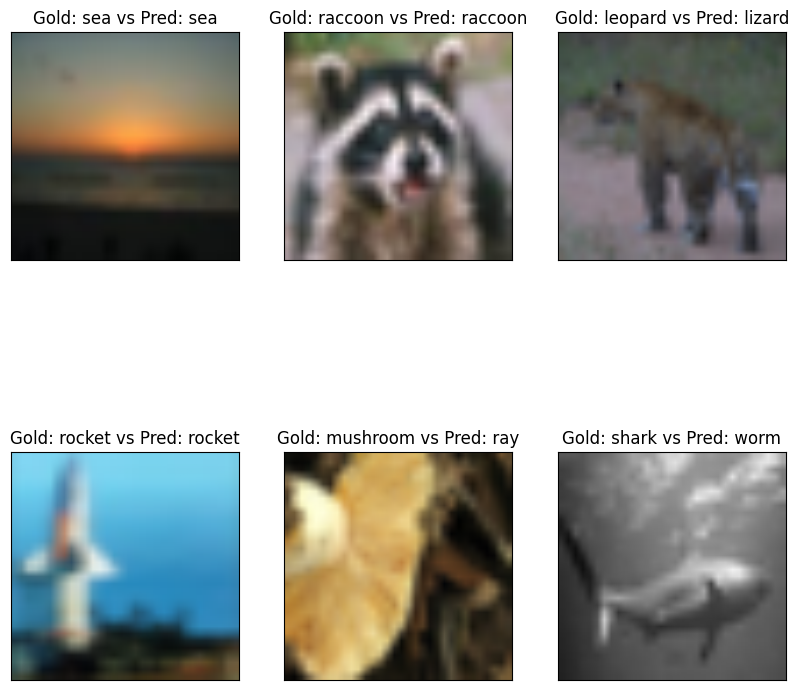

In [12]:
import random
from matplotlib import pyplot as plt

def plot_in_subplots(subplot, imgs, gold_lbls, out):
    for ax, img, g, p in zip(subplot, imgs, gold_lbls, out):
        ax.imshow(img.permute(1, 2, 0))
        p = int(p.cpu().numpy())
        ax.title.set_text(f"Gold: {idx2lbl[g]} vs Pred: {idx2lbl[p]}")
        ax.set_xticks([])
        ax.set_yticks([])

idx2lbl = {idx: label for idx, label in enumerate(val_dataset.dataset.classes)}  
indices = random.sample(range(len(val_dataset)), 6)
imgs, targets = zip(*[val_dataset[i] for i in indices])
imgs_tensor = torch.stack(imgs, dim=0)

model.module.eval()
with torch.no_grad():
    out = model(imgs_tensor.to(device)).argmax(dim=-1)
    
    plt.figure()
    f, axarr = plt.subplots(2, 3, figsize=(10, 10))
    for idx, ax in enumerate(axarr):
        plot_in_subplots(ax, imgs[3*idx: 3*(idx+1)], targets[3*idx: 3*(idx+1)], out[3*idx: 3*(idx+1)])